## LALR testing for sBQC loss

In [4]:
#My imports
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from adahessian import Adahessian, get_params_grad
import torch.optim.lr_scheduler as lr_scheduler
import math
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

# Other imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils

import warnings
import matplotlib.pyplot as plt
# import shap


In [5]:
# Loss function code:

def bareCDF(yhat, tau):
    # yhat is a torch tensor, tau is a float
    ind= (torch.sign(yhat)+1)/2 # mask about the origin
    quantFactor= (1-tau)*ind + tau*(1-ind)
    val= tau+4*quantFactor/math.pi*torch.atan(torch.tanh(yhat/2))
    # print("bareCDF val: {}".format(val))
    return val

def baresBQR(y, yhat, tau):
    # y and yhat are torch tensors, tau is a float
    val= torch.matmul(y,torch.log(1-bareCDF(yhat, tau)))+ torch.matmul((1-y),torch.log(bareCDF(yhat, tau)))
    # print("bareBQR val: {}".format(val))
    return val

class sBQRL(nn.Module):
    def __init__(self):
        super(sBQRL, self).__init__()
    
    def forward(self, y, yhat, tau):
        return baresBQR(y, yhat, tau)


In [359]:
dataset= "./Datasets/Classification/ILP.csv"
x_cols = list(range(10))
y_col = 10
separator = ","












# attribute_index =   # This controls which attribute is allowed to vary, 7,5
attribute_name = "BMI" # Name of the attribute, used in the plots, max heart rate
latent_name = "Diabetes" # Name of the function, used in the plots
# The other attributes are replaced by the median value of the attribute
Scaler= StandardScaler()
batch_is= 64

total_epochs = 20

### 
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio, ditch_head=True):
    with open(dataset, 'r') as f:
        lines = f.readlines()
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        X.append(point)
        Y.append(float(all_columns[target_column]))
    X_arr = np.asarray(X)
    X_unscaled = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = 0
    Y_arr_binary = np.where(Y_arr<=thresh,0,1)
    unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr_binary, test_size = split_ratio)
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, X_unscaled

###
X_train,X_val,y_train,y_val, data_Y, data_X_scaled, data_X_unscaled = create_xy(dataset, x_cols, y_col, separator, 0.4, ditch_head= remove_head)
shap_x_train = X_train.copy()
shap_x_val = X_val.copy()
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
# y_train= F.one_hot(y_train.to(torch.int64), num_classes=2)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
# y_val= F.one_hot(y_val.to(torch.int64), num_classes=2)
train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
train_loader = data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
test_loader = data_utils.DataLoader(test_dataset,batch_size =batch_is,pin_memory=True,shuffle = False,num_workers = 1)

IndexError: list index out of range

In [331]:
# Network definition:
class LALRnetwork(nn.Module):
    def __init__(self, indim):
        super(LALRnetwork,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,10)
        self.l3 = nn.Linear(10,1)
        
    def forward(self,x):
        x = F.tanh(self.l1(x))
        x = F.tanh(self.l2(x))
        # x = F.softmax(self.l3(x))
        x = F.sigmoid(self.l3(x))
        # x= torch.sign(x-torch.ones_like(x)*0.5)
        # x= (x+torch.ones_like(x))/2
        return x
    
    # Used in LALR
    def penU(self, x):
        op = F.tanh(self.l1(x))
        op = F.tanh(self.l2(op))
        return op


In [332]:
# Global initialisations:
device= ('cuda' if torch.cuda.is_available() else 'cpu')
indim = X_train.shape[1]
modelLALR_sBQC = LALRnetwork(indim).to(device)
modelCLR_sBQC= LALRnetwork(indim).to(device)
modelLALR_BCE= LALRnetwork(indim).to(device)
modelCLR_BCE= LALRnetwork(indim).to(device)
modelLBFGS_sBQC = LALRnetwork(indim).to(device)

criterion= sBQRL()
criterion_= nn.BCELoss()
h= 0.4
lr_is = 1e-2
optimizerLALR_sBQC= torch.optim.Adam(modelLALR_sBQC.parameters(), lr = lr_is)
optimizerLALR_BCE= torch.optim.Adam(modelLALR_BCE.parameters(), lr = lr_is)
optimizerCLR_sBQC= torch.optim.Adam(modelCLR_sBQC.parameters(), lr = lr_is)
optimizerCLR_BCE= torch.optim.Adam(modelCLR_BCE.parameters(), lr = lr_is)
optimizerLBFGS_sBQC= torch.optim.LBFGS(modelLBFGS_sBQC.parameters(), lr = lr_is)

all_qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
all_qs = torch.Tensor(all_qs).to(device)
mean_is = 0
std_is = 1
penalty = 1
alpha = 0.0
tau= 0.2

ls_list_LALR_sBQC= []
val_list_LALR_sBQC= []
acc_list_LALR_sBQC= []
ls_list_CLR_sBQC= []
val_list_CLR_sBQC= []
acc_list_CLR_sBQC= []
ls_list_LALR_BCE= []
val_list_LALR_BCE= []
acc_list_LALR_BCE= []
ls_list_CLR_BCE= []
val_list_CLR_BCE= []
acc_list_CLR_BCE= []

ls_list_LBFGS_sBQC= []
val_list_LBFGS_sBQC= []
acc_list_LBFGS_sBQC= []

In [333]:
# training loops:
def trainConstantLR(model, trainLoader, valLoader, optimizer, criterion, tau, epochs, ls_list, valList, acc_list, loss_name= "sBQC"):
    """
    Training loop used for CLR training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            optimizer.zero_grad() 
            outputs= model(inputs) 
            # loss= criterion(torch.unsqueeze(labels, 1), outputs, tau) 
            # print(outputs, labels)
            # outputs= outputs.to(torch.LongTensor()).to(device)
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            # loss= criterion(outputs, labels) # works for one hot encoding and BCE
            # loss= criterion(outputs, torch.unsqueeze(labels, 1))#, tau) 
            loss.backward() 
            optimizer.step() 
            epoch_loss+= loss.item()
        ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        num_correct= 0
        total= 0 
        model.eval()
        for inputs, labels in valLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            val_loss+= loss.item()
            x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
            num_correct += (x==labels).sum()
            total += labels.size(0)
        valList.append(val_loss/len(valLoader))
        acc_list.append(float(num_correct)/float(total)*100)
        print("Epoch: {} Training Loss: {} Validation loss: {} Accuracy: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(valLoader),
         float(num_correct)/float(total)*100))


def trainLALR(model, trainLoader, valLoader, optimizer, criterion, tau, epochs, ls_list, valList, acc_list, mask, loss_name= "sBQC"):
    """
    Training loop used for LALR training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        lr_val= computeLR(model,train_loader, mask, tau, bSize= batch_is)
        optimizer.param_groups[0]['lr']= lr_val
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            optimizer.zero_grad() 
            outputs= model(inputs) 
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            loss.backward() 
            optimizer.step() 
            epoch_loss+= loss.item()
        ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        num_correct= 0
        total= 0 
        model.eval()
        for inputs, labels in valLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            if loss_name== "BCE":
                loss= criterion_(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            val_loss+= loss.item()
            x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
            num_correct += (x==labels).sum()
            total += labels.size(0)
        valList.append(val_loss/len(valLoader))
        acc_list.append(float(num_correct)/float(total)*100)
        print("Epoch: {} Training Loss: {} Validation loss: {} LR: {} Accuracy: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(valLoader), optimizer.param_groups[0]['lr'], float(num_correct)/float(total)*100))

def trainLBFGS(model, trainLoader, valLoader, optimizer, criterion, tau, epochs, ls_list, valList, acc_list, loss_name= "sBQC"):
    """
    Training loop used for LBFGS and conjugate gradient training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            def closure():
                optimizer.zero_grad()
                outputs= model(inputs)
                if loss_name== "BCE":
                    loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
                elif loss_name== "sBQC":
                    loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
                loss.backward()
                return loss
            # optimizer.step(closure)
            # optimizer.zero_grad() 
            # outputs= model(inputs) 
            # loss= criterion(outputs, labels, tau, h) 
            # loss.backward()
            optimizer.step(closure) 
        # ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        num_correct= 0
        total= 0 
        model.eval()
        for inputs, labels in valLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            val_loss+= loss.item()
            x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
            num_correct += (x==labels).sum()
            total += labels.size(0)
        valList.append(val_loss/len(valLoader))
        acc_list.append(float(num_correct)/float(total)*100)
        print("Epoch: {} Training Loss: {} Validation loss: {} Accuracy: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(valLoader),
         float(num_correct)/float(total)*100))

# def computeLR(model, trainLoader, mask, tau, bSize= 16):
#     """
#     Takes in a network of the LALRnetwork class(during some arbitrary EPOCH of training) and the current input, and returns Kz for the EPOCH
#     """
#     Kz = 0.0
#     model.eval()
#     with torch.no_grad():
#         for i,j in enumerate(trainLoader):
#             inputs,labels= j[0],j[1]
#             inputs= inputs.to(device)
#             labels= labels.to(device)
#             op1= model.penU(inputs)
#             # first taking the max and min for each batch
#             activ1, indx1= torch.max(op1, dim= 1)
#             # val1= torch.linalg.norm(op1)
#             # now, we take the max and min across batches
#             val1, indx2= torch.max(activ1, dim= 0)
#             # print(indx, i)
#             if val1 > Kz:
#                 # in the case of K_z, we do not need the index where the max occurs, hence only deal with the value
#                 Kz= val1 
#     factor= 1
#     if mask == 1:
#         factor =  max(2/math.pi, 2-2*tau/(math.pi*tau), 2*tau/(math.pi*(1-tau)))
#     else:
#         factor= 0.5
#     LR= (factor*Kz)/bSize
#     # if LR == 0:
#     #     return 0.1
#     return (1/LR)*0.01

def computeLR(model, trainLoader, mask, tau, bSize= 16):
    """
    Takes in a network of the LALRnetwork class(during some arbitrary EPOCH of training) and the current input, and returns Kz for the EPOCH
    """
    Kz = 0.0
    # Ka= 0.0
    # Y= 0.0
    # z_k= 0.0
    model.eval()
    with torch.no_grad():
        for i,j in enumerate(trainLoader):
            inputs,labels= j[0],j[1]
            inputs= inputs.to(device)
            labels= labels.to(device)
            op1= model.penU(inputs)
            # op2= model(inputs)
            # first taking the max and min for each batch
            val1= torch.linalg.norm(op1)
            # activ1, arg1= torch.max(op1, dim= 1)
            # activ2, arg2= torch.min(op2, dim= 1)
            # now, we take the max and min across batches
            # val1, indx1= torch.max(activ1, dim= 0)
            # val2, indx2= torch.min(activ2, dim= 0)
            # val3= computeKa(op2)
            # val4= computeKa(labels)
            if val1 > Kz:
                # in the case of K_z, we do not need the index where the max occurs, hence only deal with the value
                Kz= val1 
            # z_k= val2
            # if val3 > Ka:
            #     Ka= val3
            # if val3 > Y:
            #     Y= val4 

    LR= 1
    factor= 1
    if mask== 1: 
        LR=  max(2/math.pi, 2-2*tau/(math.pi*tau), 2*tau/(math.pi*(1-tau)))*Kz*(1/bSize)
        factor= 0.15
    else:
        LR= 0.5*Kz*(1/bSize)
        factor= 0.05

    return (1/LR)*factor

In [338]:
# LALR, sBQC
trainLALR(modelLALR_sBQC, train_loader, test_loader, optimizerLALR_sBQC, criterion, tau, 10, ls_list_LALR_sBQC, val_list_LALR_sBQC, acc_list_LALR_sBQC, 1, "sBQC")

Epoch: 0 Training Loss: -82.61404854910714 Validation loss: -76.59082870483398 LR: 0.2785671651363373 Accuracy: 96.78571428571429
Epoch: 1 Training Loss: -82.61404691423688 Validation loss: -76.59082870483398 LR: 0.27856260538101196 Accuracy: 96.78571428571429
Epoch: 2 Training Loss: -82.61405181884766 Validation loss: -76.59082870483398 LR: 0.27859219908714294 Accuracy: 96.78571428571429
Epoch: 3 Training Loss: -82.61405072893415 Validation loss: -76.59082870483398 LR: 0.2785593569278717 Accuracy: 96.78571428571429
Epoch: 4 Training Loss: -82.61405072893415 Validation loss: -76.59082870483398 LR: 0.27857473492622375 Accuracy: 96.78571428571429
Epoch: 5 Training Loss: -82.61404800415039 Validation loss: -76.59082870483398 LR: 0.2785775065422058 Accuracy: 96.78571428571429
Epoch: 6 Training Loss: -82.61404691423688 Validation loss: -76.59082870483398 LR: 0.27853670716285706 Accuracy: 96.78571428571429
Epoch: 7 Training Loss: -82.61404963902065 Validation loss: -76.59082870483398 LR: 0.2

In [343]:
# LALR, BCE
trainLALR(modelLALR_BCE, train_loader, test_loader, optimizerLALR_BCE, criterion_, tau, 10, ls_list_LALR_BCE, val_list_LALR_BCE, acc_list_LALR_BCE, 2, "BCE")

Epoch: 0 Training Loss: 0.12448933933462415 Validation loss: 0.1374417930841446 LR: 0.2529822289943695 Accuracy: 96.07142857142857
Epoch: 1 Training Loss: 0.12648398748465947 Validation loss: 0.13920720666646957 LR: 0.2529822289943695 Accuracy: 96.07142857142857
Epoch: 2 Training Loss: 0.14573547882693155 Validation loss: 0.13689088076353073 LR: 0.2529822289943695 Accuracy: 96.07142857142857
Epoch: 3 Training Loss: 0.12040134359683309 Validation loss: 0.15340058803558348 LR: 0.2529822289943695 Accuracy: 96.07142857142857
Epoch: 4 Training Loss: 0.11276280161525522 Validation loss: 0.14005544334650039 LR: 0.2529822289943695 Accuracy: 96.07142857142857
Epoch: 5 Training Loss: 0.1231042854487896 Validation loss: 0.1441948965191841 LR: 0.2529822289943695 Accuracy: 96.07142857142857
Epoch: 6 Training Loss: 0.12198963521846704 Validation loss: 0.14046140015125275 LR: 0.2529822289943695 Accuracy: 96.07142857142857
Epoch: 7 Training Loss: 0.14312632834272726 Validation loss: 0.1406748846173286

In [348]:
# CLR, sBQC
trainConstantLR(modelCLR_sBQC, train_loader, test_loader, optimizerCLR_sBQC, criterion, tau, 10, ls_list_CLR_sBQC, val_list_CLR_sBQC, acc_list_CLR_sBQC, "sBQC")

Epoch: 0 Training Loss: -82.66187776838031 Validation loss: -76.0363983154297 Accuracy: 95.71428571428572
Epoch: 1 Training Loss: -82.66593061174665 Validation loss: -76.04040069580078 Accuracy: 95.71428571428572
Epoch: 2 Training Loss: -82.66975130353656 Validation loss: -76.04437255859375 Accuracy: 95.71428571428572
Epoch: 3 Training Loss: -82.67333439418248 Validation loss: -76.0484405517578 Accuracy: 95.71428571428572
Epoch: 4 Training Loss: -82.67677307128906 Validation loss: -76.05205535888672 Accuracy: 95.71428571428572
Epoch: 5 Training Loss: -82.68001556396484 Validation loss: -76.05561218261718 Accuracy: 95.71428571428572
Epoch: 6 Training Loss: -82.68309075491769 Validation loss: -76.05853576660157 Accuracy: 95.71428571428572
Epoch: 7 Training Loss: -82.686037336077 Validation loss: -76.06159591674805 Accuracy: 95.71428571428572
Epoch: 8 Training Loss: -82.68882424490792 Validation loss: -76.06456298828125 Accuracy: 95.71428571428572
Epoch: 9 Training Loss: -82.6914754595075

In [353]:
# CLR, BCE
trainConstantLR(modelCLR_BCE, train_loader, test_loader, optimizerCLR_BCE, criterion_, tau, 10, ls_list_CLR_BCE, val_list_CLR_BCE, acc_list_CLR_BCE, "BCE")

Epoch: 0 Training Loss: 0.030538431368768215 Validation loss: 0.16661071367561817 Accuracy: 94.64285714285714
Epoch: 1 Training Loss: 0.03177786388966654 Validation loss: 0.1677365081384778 Accuracy: 94.64285714285714
Epoch: 2 Training Loss: 0.02984937440071787 Validation loss: 0.16853549033403398 Accuracy: 95.0
Epoch: 3 Training Loss: 0.02936616456801338 Validation loss: 0.16690744888037443 Accuracy: 95.0
Epoch: 4 Training Loss: 0.029072684501963004 Validation loss: 0.1692367303185165 Accuracy: 95.0
Epoch: 5 Training Loss: 0.0284194827212819 Validation loss: 0.1699464414268732 Accuracy: 95.0
Epoch: 6 Training Loss: 0.02837654422702534 Validation loss: 0.1717002395540476 Accuracy: 95.0
Epoch: 7 Training Loss: 0.029502880327137455 Validation loss: 0.17348455544561148 Accuracy: 95.0
Epoch: 8 Training Loss: 0.02577961183020047 Validation loss: 0.17240577144548297 Accuracy: 95.0
Epoch: 9 Training Loss: 0.025805150624364614 Validation loss: 0.17249278202652932 Accuracy: 95.0


In [84]:
# LBFGS, sBQC
trainLBFGS(modelLBFGS_sBQC, train_loader, test_loader, optimizerLBFGS_sBQC, criterion, tau, 10, ls_list_LBFGS_sBQC, val_list_LBFGS_sBQC, acc_list_LBFGS_sBQC, "sBQC")

Epoch: 0 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541
Epoch: 1 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541
Epoch: 2 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541
Epoch: 3 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541
Epoch: 4 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541
Epoch: 5 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541
Epoch: 6 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541
Epoch: 7 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541
Epoch: 8 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541
Epoch: 9 Training Loss: 0.0 Validation loss: -67.76021575927734 Accuracy: 81.9672131147541


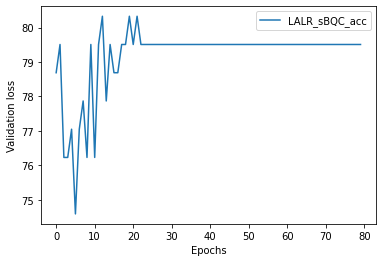

In [17]:
# error plots
# plt.plot(range(10), ls_list_LALR_sBQC)
# plt.plot(range(len(val_list_LALR_sBQC)), val_list_LALR_sBQC, label= "LALR_sBQC")
# plt.plot(range(len(ls_list_LALR_sBQC)), ls_list_LALR_sBQC, label= "LALR_sBQC_ls")
# plt.plot(range(len(val_list_CLR_sBQC)), val_list_CLR_sBQC, label= "CLR_sBQC")
# plt.plot(range(len(val_list_LALR_sBQC)), val_list_LALR_BCE, label= "LALR_BCE")
# plt.plot(range(len(val_list_CLR_sBQC)), val_list_CLR_BCE, label= "CLR_BCE")
# plt.plot(range(len(acc_list_CLR_BCE)), acc_list_CLR_BCE, label= "CLR_BCE_acc")
# plt.plot(range(len(acc_list_CLR_sBQC)), acc_list_CLR_sBQC, label= "CLR_sBQC_acc")
# plt.plot(range(len(acc_list_LALR_BCE)), acc_list_LALR_BCE, label= "LALR_BCE_acc")
# plt.plot(range(len(acc_list_LALR_sBQC)), acc_list_LALR_sBQC, label= "LALR_sBQC_acc")
# plt.plot(range(len(val_list_LBFGS_sBQC)), val_list_LBFGS_sBQC, label= "LBFGS_sBQC_val")
# plt.plot(range(len(acc_list_LBFGS_sBQC)), acc_list_LBFGS_sBQC, label= "LBFGS_sBQC_acc")
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.legend()

In [354]:
# metrics:
def computeMetrics(model):
    outputs= torch.Tensor([])
    outputs= outputs.to(device)
    labels= torch.Tensor([])
    labels= labels.to(device)
    for inputs, label in test_loader:
        inputs= inputs.to(device)
        label= label.to(device)
        output= model(inputs)
        outputs= torch.cat((outputs, output))
        labels= torch.cat((labels, label))
    x= outputs
    x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
    CP= cohen_kappa_score(labels.detach().to('cpu').numpy(), x.detach().to('cpu').numpy())
    JS= jaccard_score(labels.detach().to('cpu').numpy(), x.detach().to('cpu').numpy())
    F1= f1_score(labels.detach().to('cpu').numpy(), x.detach().to('cpu').numpy())
    return [CP, JS, F1]

In [358]:
computeMetrics(modelLALR_BCE)

[0.9154125013731736, 0.8981481481481481, 0.9463414634146342]